In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from evaluate import utils
# types for type hinting


In [2]:
# Read the CSV file
file_path = '../cme_and_electron/cme_josias_10MeV.csv'
df = pd.read_csv(file_path)

In [3]:
def split_data(df):
    """
    Splits the data into training, validation, and test sets according to the specified rules.
    
    :param:
    - df: DataFrame containing the data. Assumes 'log_peak_intensity' is the target column.
    
    :return:
    - train_x, train_y, val_x, val_y, test_x, test_y: Numpy arrays containing the split data
    """
    # Sort the DataFrame by 'log_peak_intensity' in descending order
    df_sorted = df.sort_values(by='log_peak_intensity', ascending=False).reset_index(drop=True)
    
    # Initialize empty lists to store indices for training, validation, and test sets
    train_indices = []
    val_indices = []
    test_indices = []
    
    # Group every 3 rows for test set selection
    for i in range(0, len(df_sorted), 3):
        group = list(range(i, min(i + 3, len(df_sorted))))
        test_idx = np.random.choice(group, 1)[0]
        train_indices.extend([idx for idx in group if idx != test_idx])
        test_indices.append(test_idx)
    
    # Group every 4 rows for validation set selection from the training set
    for i in range(0, len(train_indices), 4):
        group = train_indices[i: i + 4]
        if len(group) == 0:
            continue
        val_idx = np.random.choice(group, 1)[0]
        val_indices.append(val_idx)
        train_indices = [idx for idx in train_indices if idx != val_idx]
    
    # Extract the feature and target sets based on selected indices
    features = df_sorted.drop(columns=['log_peak_intensity']).to_numpy()
    target = df_sorted['log_peak_intensity'].to_numpy()
    
    train_x = features[train_indices]
    train_y = target[train_indices]
    val_x = features[val_indices]
    val_y = target[val_indices]
    test_x = features[test_indices]
    test_y = target[test_indices]
    
    return train_x, train_y, val_x, val_y, test_x, test_y

# Test the function
train_x, train_y, val_x, val_y, test_x, test_y = split_data(df)

# Show the shape of the resulting arrays to ensure correctness
(train_x.shape, train_y.shape), (val_x.shape, val_y.shape), (test_x.shape, test_y.shape)


(((1225, 19), (1225,)), ((307, 19), (307,)), ((766, 19), (766,)))

In [4]:
def plot_sorted_distributions(y_train, y_val, y_test, title='Sorted Distributions'):
    """
    Plots the sorted target variable distributions for the training, validation, and test sets.
    
    :param:
    - y_train: Numpy array containing the training set target variable
    - y_val: Numpy array containing the validation set target variable
    - y_test: Numpy array containing the test set target variable
    - title: Title for the plot
    """
    plt.figure(figsize=(12, 6))
    
    # Sort and plot the target variable for each set
    plt.plot(np.sort(y_train), label='Train', marker='o')
    plt.plot(np.sort(y_val), label='Validation', marker='x')
    plt.plot(np.sort(y_test), label='Test', marker='s')
    
    plt.xlabel('Index')
    plt.ylabel('log_peak_intensity')
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()

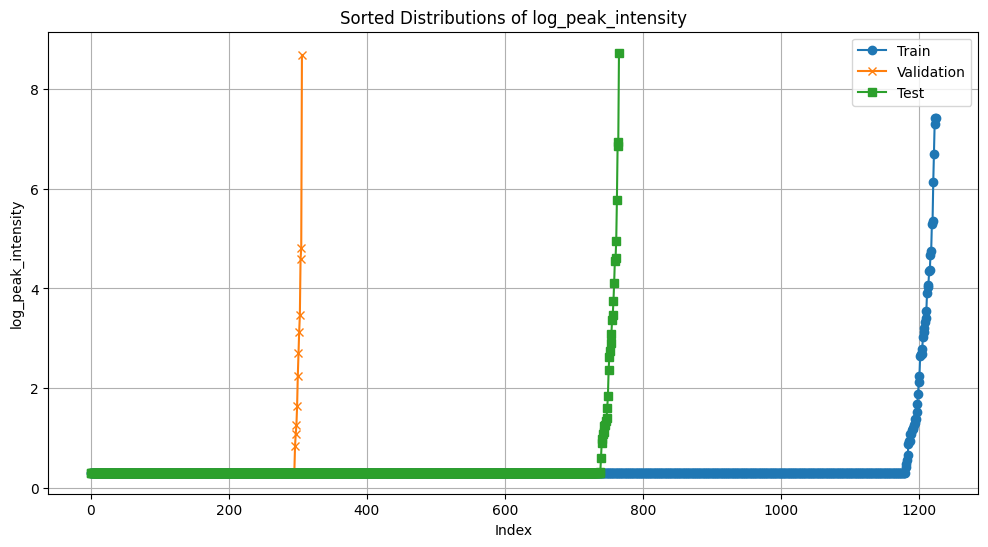

In [5]:
plot_sorted_distributions(train_y, val_y, test_y, title='Sorted Distributions of log_peak_intensity')

In [6]:
def shuffle_sets(train_x, train_y, val_x, val_y, test_x, test_y):
    """
    Shuffle the data within each of the training, validation, and test sets.
    
    :param:
    - train_x, train_y: Numpy arrays containing the training features and labels
    - val_x, val_y: Numpy arrays containing the validation features and labels
    - test_x, test_y: Numpy arrays containing the test features and labels
    
    :return:
    - Shuffled versions of train_x, train_y, val_x, val_y, test_x, test_y
    """
    train_x, train_y = shuffle(train_x, train_y)
    val_x, val_y = shuffle(val_x, val_y)
    test_x, test_y = shuffle(test_x, test_y)
    
    return train_x, train_y, val_x, val_y, test_x, test_y

# Shuffle the datasets
shuffled_train_x, shuffled_train_y, shuffled_val_x, shuffled_val_y, shuffled_test_x, shuffled_test_y = shuffle_sets(train_x, train_y, val_x, val_y, test_x, test_y)


In [7]:
elevateds, seps = utils.count_above_threshold(shuffled_train_y)
print(f'Sub-Training set: elevated events: {elevateds}  and sep events: {seps}')
elevateds, seps = utils.count_above_threshold(shuffled_val_y)
print(f'Validation set: elevated events: {elevateds}  and sep events: {seps}')
elevateds, seps = utils.count_above_threshold(shuffled_test_y)
print(f'Test set: elevated events: {elevateds}  and sep events: {seps}')


Sub-Training set: elevated events: 21  and sep events: 24
Validation set: elevated events: 5  and sep events: 6
Test set: elevated events: 12  and sep events: 16


In [8]:
from models import modeling
from sklearn.manifold import TSNE

In [9]:
mb = modeling.ModelBuilder()

# create my feature extractor
feature_extractor = mb.create_model_pds(input_dim=19, feat_dim=9, hiddens=[18], output_dim=1, with_ae=True, with_reg=True)

In [10]:
# print model summary
feature_extractor.summary()
mb.plot_model(feature_extractor)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 19)]         0           []                               
                                                                                                  
 dense (Dense)                  (None, 18)           360         ['input_1[0][0]']                
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 18)           0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 9)            171         ['leaky_re_lu[0][0]']            
                                                                                              

TypeError: plot_model() missing 1 required positional argument: 'name'

In [10]:
# add the head
reg = mb.add_reg_proj_head(feature_extractor, pds=True)


Features are frozen: True


In [11]:
# print model summary
reg.summary()
mb.plot_model(reg)

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 19)]              0         
                                                                 
 dense_3 (Dense)             (None, 18)                360       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 18)                0         
                                                                 
 dense_4 (Dense)             (None, 9)                 171       
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 9)                 0         
                                                                 
 normalize_layer (NormalizeL  (None, 9)                0         
 ayer)                                                           
                                                           

In [13]:
def plot_tsne(model, X, y, threshold=np.log(9)):
    """
    Applies t-SNE to the features extracted by the given model and plots them in 2D.
    The color of the points is determined by their label values. Points above a certain
    threshold are plotted last to be more visible.
    
    Parameters:
    - model: Trained feature extractor model
    - X: Input data
    - y: Target labels
    - threshold: Label value above which points are considered "above threshold"
    
    Returns:
    - A 2D t-SNE plot
    """
    # Extract features using the trained model
    features = model.predict(X)
    
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(features)
    
    # Identify above and below threshold indices
    above_threshold_indices = np.where(y > threshold)[0]
    below_threshold_indices = np.where(y <= threshold)[0]
    
    # Create scatter plot for below-threshold points
    plt.figure(figsize=(12, 8))
    plt.scatter(tsne_result[below_threshold_indices, 0], tsne_result[below_threshold_indices, 1], 
                c=y[below_threshold_indices], cmap='viridis', alpha=0.6, label='Below Threshold')
    
    # Overlay scatter plot for above-threshold points
    scatter = plt.scatter(tsne_result[above_threshold_indices, 0], tsne_result[above_threshold_indices, 1], 
                          c=y[above_threshold_indices], cmap='viridis', alpha=1.0, edgecolors='r', label='Above Threshold')
    
    # Add a color bar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Label Value')

    # Add legend to differentiate above-threshold points
    plt.legend()
    
    plt.title('2D t-SNE Visualization')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.show()

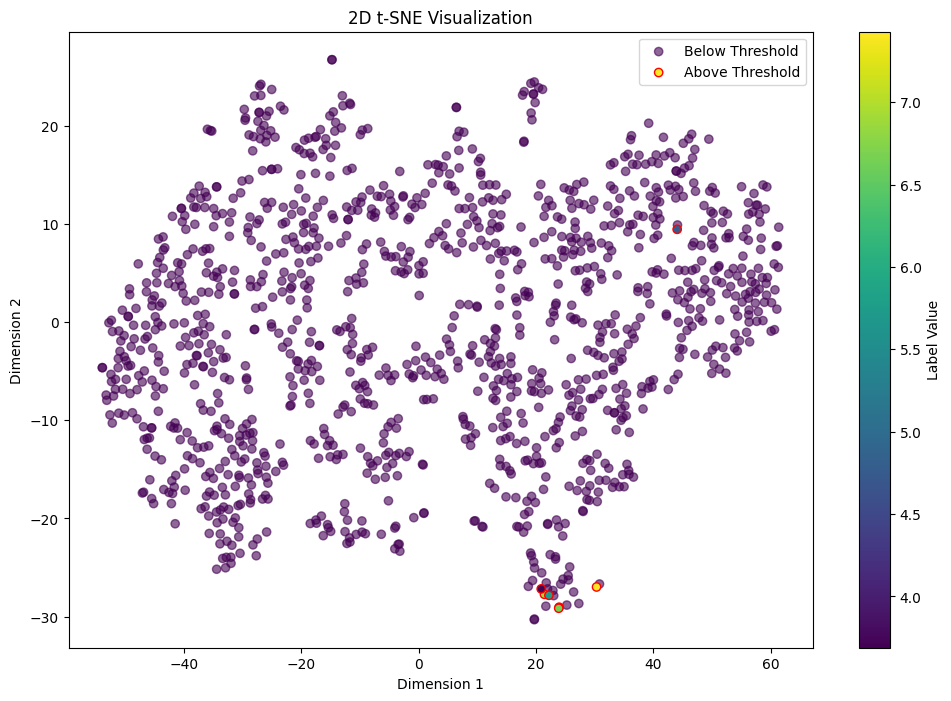

In [14]:
plot_tsne(feature_extractor, shuffled_train_x, shuffled_train_y)

In [12]:
import  random
def find_optimized_random_batch_size(y, threshold=np.log(10), num_trials=1000, early_exit_ratio=0.95):
    """
    Optimized function to find the minimum batch size such that, when sampled at random,
    each batch is likely to contain at least 2 rows with target values greater than a given threshold.
    
    Parameters:
    - y: Numpy array containing the target values
    - threshold: The target threshold, default is ln(10)
    - num_trials: Number of trials to perform for each batch size
    - early_exit_ratio: The success ratio to achieve before stopping the trials for a given batch size
    
    Returns:
    - Minimum batch size that fulfills the condition
    """
    # Count the number of elements greater than the threshold
    count_above_threshold = np.sum(y > threshold)
    
    # If there are fewer than 2 elements above the threshold, return a message
    if count_above_threshold < 2:
        raise ValueError("There are not enough samples with target values greater than the threshold.")
    
    # Loop through possible batch sizes, starting from 2
    for batch_size in range(2, len(y) + 1):
        print(batch_size)
        success_count = 0
        
        for trial in range(num_trials):
            # Sample a random batch
            random_batch = random.sample(list(y), batch_size)
            
            # Check if the batch contains at least 2 elements greater than the threshold
            if np.sum(np.array(random_batch) > threshold) >= 2:
                success_count += 1
            
            # Early exit if success ratio is achieved
            if trial >= 1000 and success_count / (trial + 1) >= early_exit_ratio:
                return batch_size

# Find the minimum batch size for the training set that satisfies the condition, using the optimized function
min_optimized_random_batch_size = find_optimized_random_batch_size(shuffled_train_y, num_trials=10000, early_exit_ratio=0.99)

min_optimized_random_batch_size


2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277
27

282

Run the command line:
 tensorboard --logdir logs/fit
158/158 [==============================] - 8s 39ms/step - loss: 5.9883 - val_loss: 15.3841


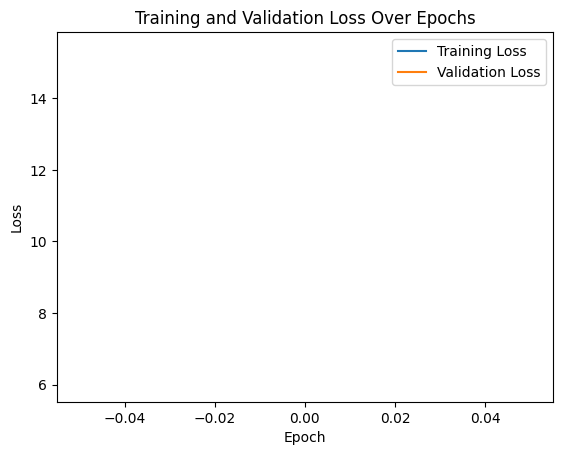

198/198 [==============================] - 9s 41ms/step - loss: 7.9071


In [16]:
mb.train_pds(feature_extractor, shuffled_train_x, shuffled_train_y, shuffled_val_x, shuffled_val_y, epochs=1, batch_size=8, learning_rate=.01, patience=12, save_tag='test')

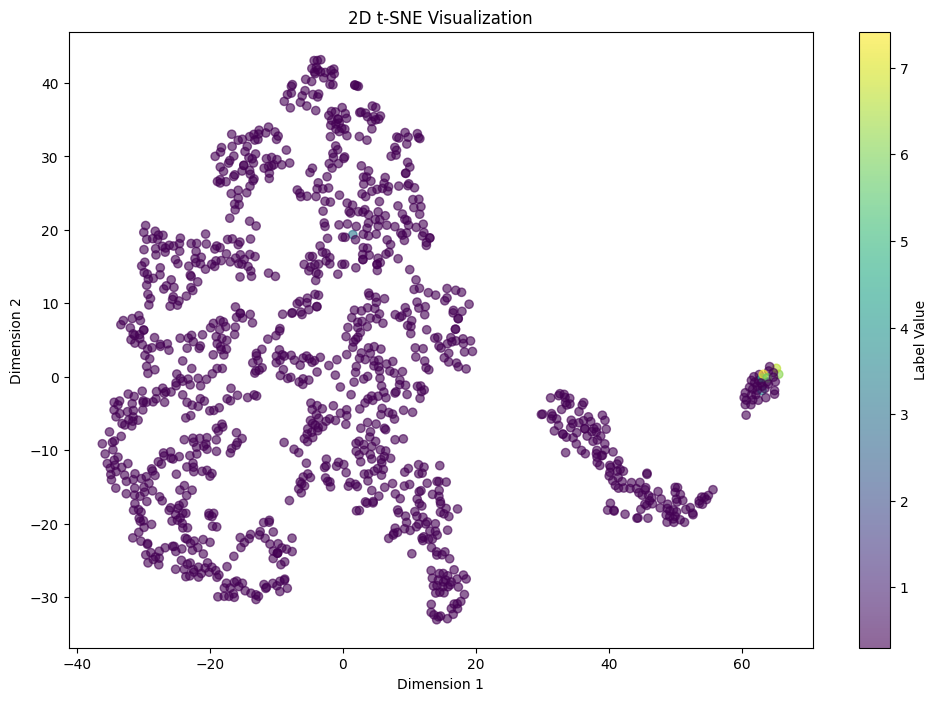

In [21]:
plot_tsne(feature_extractor, shuffled_train_x, shuffled_train_y)

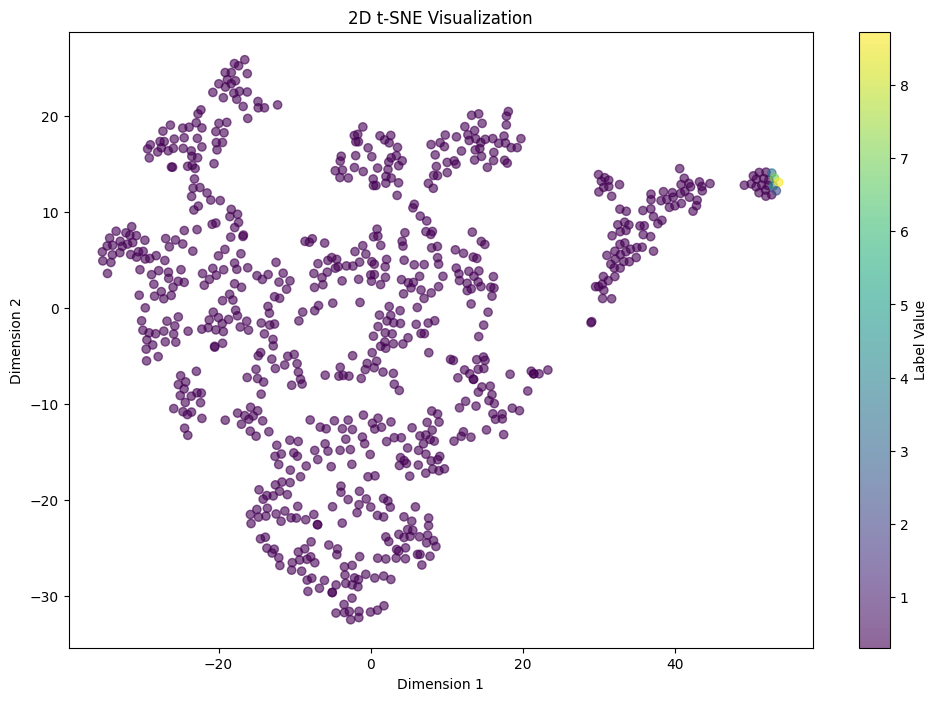

In [22]:
plot_tsne(feature_extractor, shuffled_test_x, shuffled_test_y)